In [1]:
%matplotlib inline

# install pillow
!pip install Pillow -U

# download and unzip dataset o train
!wget http://images.cocodataset.org/zips/val2014.zip
!mkdir train
%cd /content/train
!unzip -qq /content/val2014.zip
%cd ..

#download model
!wget https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth

     |████████████████████████████████| 4.3 MB 5.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


--2022-04-25 04:36:52--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.232.27
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.232.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  56.1MB/s    in 1m 48s  

2022-04-25 04:38:41 (58.6 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]

/content/train
/content
--2022-04-25 04:39:21--  https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553451520 (528M) [application/x-tar]
Saving to: ‘vgg16-00b39a1b.pth’

vgg16-00b39a1b.pth  100%[===================>] 527.81M  86.8MB/s    in 6.3s    

2022-0

In [1]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import random
import numpy as np
import time
import vgg16_fe as vgg # this is used to extract features
import custom_model
import utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Global variables
TRAIN_IMAGE_SIZE = 256
DATASET_PATH = "train"
NUM_EPOCHS = 1
STYLE_IMAGE_PATH = "style/rain_princess.jpg"
BATCH_SIZE = 4 
CONTENT_WEIGHT = 17 # 17
STYLE_WEIGHT = 50 # 25
ADAM_LR = 0.001
SAVE_MODEL_PATH = "models/"
SAVE_IMAGE_PATH = "images/out/"
SAVE_MODEL_EVERY = 500 # 2,000 Images with batch size 4
SEED = 35
PLOT_LOSS = 1

In [4]:
def train():
    # seeds
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    # get the device
    device = ("cuda" if torch.cuda.is_available() else "cpu")

    # load the training dataset
    transform = transforms.Compose([
        transforms.Resize(TRAIN_IMAGE_SIZE),
        transforms.CenterCrop(TRAIN_IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])

    train_dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # load the models and start training :)
    model = custom_model.CustomModel().to(device)
    vgg16_fe = vgg.VGG16('/content/vgg16-00b39a1b.pth').to(device)

    # get style features
    imagenet_neg_mean = torch.tensor([-103.939, -116.779, -123.68], dtype=torch.float32).reshape(1,3,1,1).to(device)
    # load the style image
    style_image = utils.load_image(STYLE_IMAGE_PATH)
    # convert style image to tensor
    style_tensor = utils.itot(style_image).to(device)
    # add imagenet mean
    style_tensor = style_tensor.add(imagenet_neg_mean)

    B, C, H, W = style_tensor.shape
    # get the features of the style image
    style_features = vgg16_fe(style_tensor.expand([BATCH_SIZE, C, H, W]))

    # get the gram matrix of the style image
    style_gram = {}
    for key, value in style_features.items():
        style_gram[key] = utils.gram(value)

    # Optimizer settings
    optimizer = optim.Adam(model.parameters(), lr=ADAM_LR)

    # Loss trackers
    content_loss_history = []
    style_loss_history = []
    total_loss_history = []
    batch_content_loss_sum = 0
    batch_style_loss_sum = 0
    batch_total_loss_sum = 0

    # Optimization/Training Loop
    batch_count = 1
    start_time = time.time()

    # training loop
    for epoch in range(NUM_EPOCHS):
        print("========Epoch {}/{}========".format(epoch+1, NUM_EPOCHS))
        for content_batch, _ in train_loader:
            # Get current batch size in case of odd batch sizes
            curr_batch_size = content_batch.shape[0]

            # free up unnecessary memory of cuda
            torch.cuda.empty_cache()

            # zero the gradients
            optimizer.zero_grad()

            # Generate images and get features
            content_batch = content_batch[:,[2,1,0]].to(device)
            generated_batch = model(content_batch)
            content_features = vgg16_fe(content_batch.add(imagenet_neg_mean))
            generated_features = vgg16_fe(generated_batch.add(imagenet_neg_mean))

            # Calculate content loss
            MSELoss = nn.MSELoss().to(device)
            content_loss = CONTENT_WEIGHT * MSELoss(generated_features['relu2_2'], content_features['relu2_2'])            
            batch_content_loss_sum += content_loss

            # Calculate style loss
            style_loss = 0
            for key, value in generated_features.items():
                s_loss = MSELoss(utils.gram(value), style_gram[key][:curr_batch_size])
                style_loss += s_loss
            style_loss *= STYLE_WEIGHT
            batch_style_loss_sum += style_loss.item()

            # Calculate total loss
            total_loss = content_loss + style_loss
            batch_total_loss_sum += total_loss.item()

            # Backpropagation
            total_loss.backward()
            optimizer.step()

            # Save Model and Print Losses
            if (((batch_count-1)%SAVE_MODEL_EVERY == 0) or (batch_count==NUM_EPOCHS*len(train_loader))):
                # Print Losses
                print("========Iteration {}/{}========".format(batch_count, NUM_EPOCHS*len(train_loader)))
                print("\tContent Loss:\t{:.2f}".format(batch_content_loss_sum/batch_count))
                print("\tStyle Loss:\t{:.2f}".format(batch_style_loss_sum/batch_count))
                print("\tTotal Loss:\t{:.2f}".format(batch_total_loss_sum/batch_count))
                print("Time elapsed:\t{} seconds".format(time.time()-start_time))

                # Save Model
                checkpoint_path = SAVE_MODEL_PATH + "checkpoint_" + str(batch_count-1) + ".pth"
                torch.save(model.state_dict(), checkpoint_path)
                
                print("Saved TransformerNetwork checkpoint file at {}".format(checkpoint_path))

                # Save sample generated image
                sample_tensor = generated_batch[0].clone().detach().unsqueeze(dim=0) # clone to save inplace errors
                sample_image = utils.ttoi(sample_tensor.clone().detach())
                sample_image_path = SAVE_IMAGE_PATH + "sample0_" + str(batch_count-1) + ".png"
                utils.saveimg(sample_image, sample_image_path)
                utils.show(sample_image)
                print("Saved sample tranformed image at {}".format(sample_image_path))

                # Save loss histories
                content_loss_history.append(batch_total_loss_sum/batch_count)
                style_loss_history.append(batch_style_loss_sum/batch_count)
                total_loss_history.append(batch_total_loss_sum/batch_count)
            
            # increment batch count
            batch_count += 1
    
    stop_time = time.time()
    # Print loss histories
    print("Done Training the Transformer Network!")
    print("Training Time: {} seconds".format(stop_time-start_time))
    print("========Content Loss========")
    print(content_loss_history) 
    print("========Style Loss========")
    print(style_loss_history) 
    print("========Total Loss========")
    print(total_loss_history) 

    # Save TransformerNetwork weights
    model.eval()
    model.cpu()
    final_path = SAVE_MODEL_PATH + "transformer_weight.pth"
    print("Saving TransformerNetwork weights at {}".format(final_path))
    torch.save(model.state_dict(), final_path)
    print("Done saving final model")

    # Plot Loss Histories
    if (PLOT_LOSS):
        utils.plot_loss_hist(content_loss_history, style_loss_history, total_loss_history)


========Epoch 1/1========
========Iteration 1/10126========
	Content Loss:	3213490.00
	Style Loss:	73487872.00
	Total Loss:	76701360.00
Time elapsed:	2.3341519832611084 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_0.pth


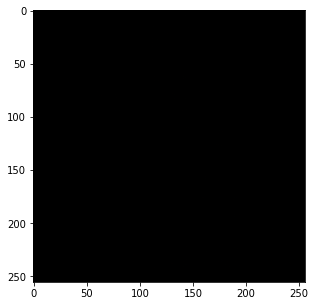

Saved sample tranformed image at images/out/sample0_0.png
========Iteration 501/10126========
	Content Loss:	4374777.00
	Style Loss:	13374644.86
	Total Loss:	17749421.72
Time elapsed:	83.52883958816528 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_500.pth


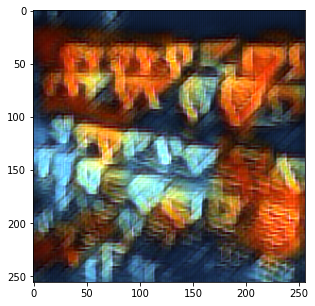

Saved sample tranformed image at images/out/sample0_500.png
========Iteration 1001/10126========
	Content Loss:	4048313.25
	Style Loss:	7756125.73
	Total Loss:	11804440.20
Time elapsed:	163.9379951953888 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_1000.pth


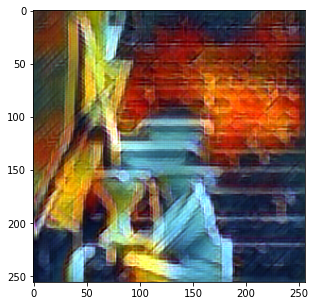

Saved sample tranformed image at images/out/sample0_1000.png
========Iteration 1501/10126========
	Content Loss:	3781209.75
	Style Loss:	5719969.78
	Total Loss:	9501176.96
Time elapsed:	243.46168303489685 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_1500.pth


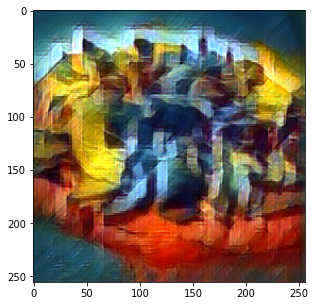

Saved sample tranformed image at images/out/sample0_1500.png
========Iteration 2001/10126========
	Content Loss:	3562812.00
	Style Loss:	4657160.53
	Total Loss:	8219971.37
Time elapsed:	322.04487347602844 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_2000.pth


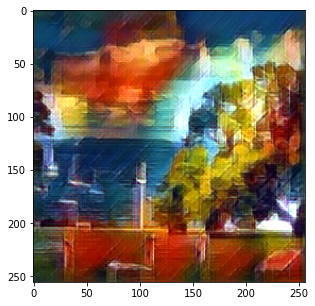

Saved sample tranformed image at images/out/sample0_2000.png
========Iteration 2501/10126========
	Content Loss:	3374063.75
	Style Loss:	3995846.88
	Total Loss:	7369909.62
Time elapsed:	400.12713146209717 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_2500.pth


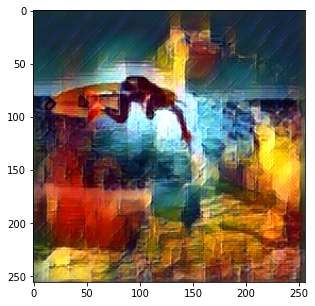

Saved sample tranformed image at images/out/sample0_2500.png
========Iteration 3001/10126========
	Content Loss:	3226332.00
	Style Loss:	3543705.61
	Total Loss:	6770033.87
Time elapsed:	477.6435089111328 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_3000.pth


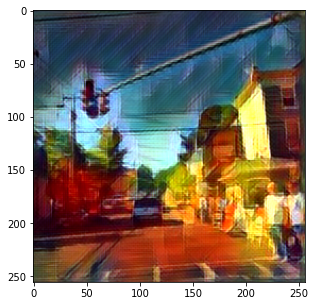

Saved sample tranformed image at images/out/sample0_3000.png
========Iteration 3501/10126========
	Content Loss:	3106288.25
	Style Loss:	3214921.25
	Total Loss:	6321209.91
Time elapsed:	554.7948098182678 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_3500.pth


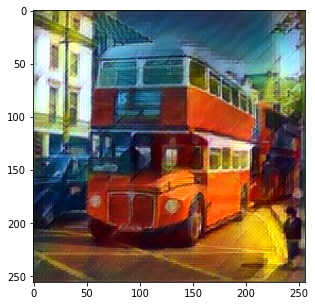

Saved sample tranformed image at images/out/sample0_3500.png
========Iteration 4001/10126========
	Content Loss:	3008742.00
	Style Loss:	2960517.45
	Total Loss:	5969262.26
Time elapsed:	631.6321051120758 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_4000.pth


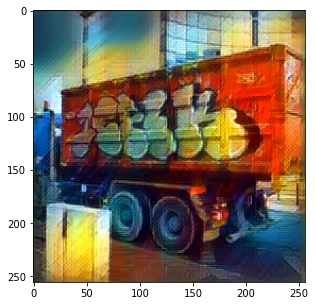

Saved sample tranformed image at images/out/sample0_4000.png
========Iteration 4501/10126========
	Content Loss:	2925001.00
	Style Loss:	2758711.46
	Total Loss:	5683714.99
Time elapsed:	708.4595811367035 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_4500.pth


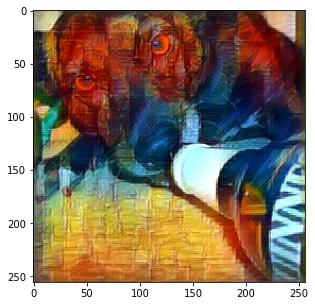

Saved sample tranformed image at images/out/sample0_4500.png
========Iteration 5001/10126========
	Content Loss:	2853001.75
	Style Loss:	2592997.36
	Total Loss:	5446002.96
Time elapsed:	785.0430381298065 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_5000.pth


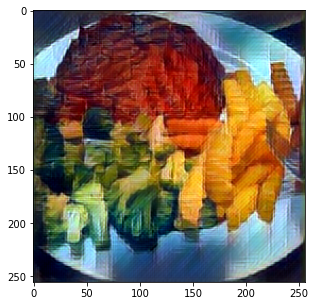

Saved sample tranformed image at images/out/sample0_5000.png
========Iteration 5501/10126========
	Content Loss:	2791213.75
	Style Loss:	2455445.56
	Total Loss:	5246660.64
Time elapsed:	861.6897296905518 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_5500.pth


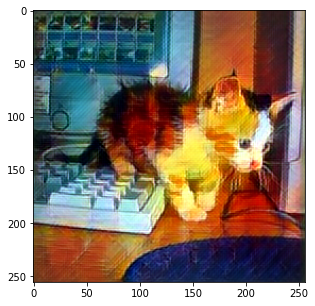

Saved sample tranformed image at images/out/sample0_5500.png
========Iteration 6001/10126========
	Content Loss:	2738691.50
	Style Loss:	2340227.98
	Total Loss:	5078920.41
Time elapsed:	937.9614207744598 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_6000.pth


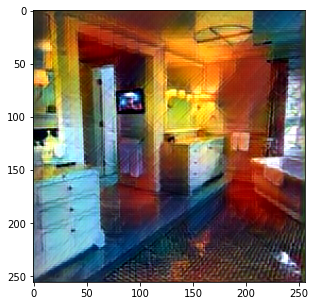

Saved sample tranformed image at images/out/sample0_6000.png
========Iteration 6501/10126========
	Content Loss:	2692155.50
	Style Loss:	2239685.14
	Total Loss:	4931839.88
Time elapsed:	1014.1923184394836 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_6500.pth


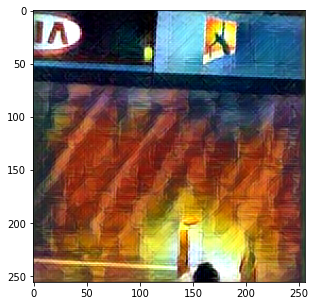

Saved sample tranformed image at images/out/sample0_6500.png
========Iteration 7001/10126========
	Content Loss:	2647582.00
	Style Loss:	2152397.83
	Total Loss:	4799980.67
Time elapsed:	1090.4509408473969 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_7000.pth


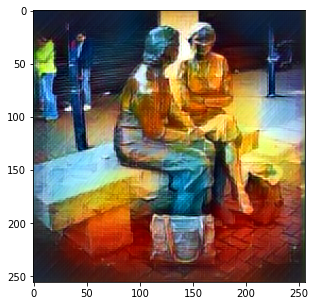

Saved sample tranformed image at images/out/sample0_7000.png
========Iteration 7501/10126========
	Content Loss:	2609283.75
	Style Loss:	2075746.86
	Total Loss:	4685033.81
Time elapsed:	1166.479619026184 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_7500.pth


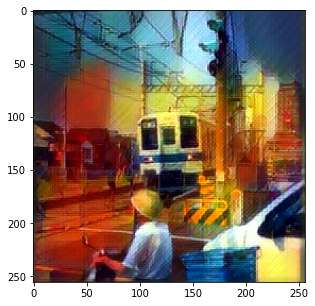

Saved sample tranformed image at images/out/sample0_7500.png
========Iteration 8001/10126========
	Content Loss:	2574388.75
	Style Loss:	2008047.30
	Total Loss:	4582437.74
Time elapsed:	1242.2430000305176 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_8000.pth


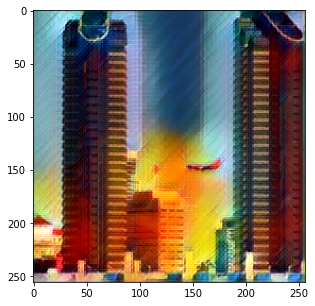

Saved sample tranformed image at images/out/sample0_8000.png
========Iteration 8501/10126========
	Content Loss:	2544100.75
	Style Loss:	1948014.75
	Total Loss:	4492117.12
Time elapsed:	1317.974380493164 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_8500.pth


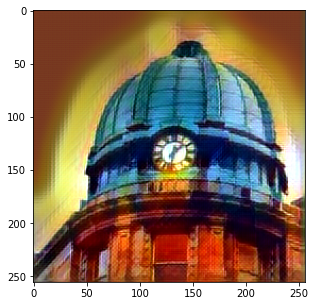

Saved sample tranformed image at images/out/sample0_8500.png
========Iteration 9001/10126========
	Content Loss:	2516032.75
	Style Loss:	1893311.80
	Total Loss:	4409344.47
Time elapsed:	1393.3382902145386 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_9000.pth


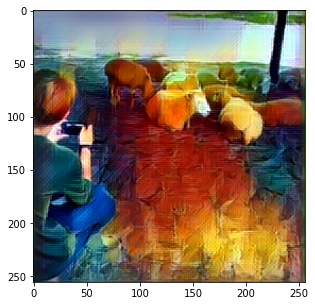

Saved sample tranformed image at images/out/sample0_9000.png
========Iteration 9501/10126========
	Content Loss:	2490650.75
	Style Loss:	1843927.16
	Total Loss:	4334578.65
Time elapsed:	1468.7982285022736 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_9500.pth


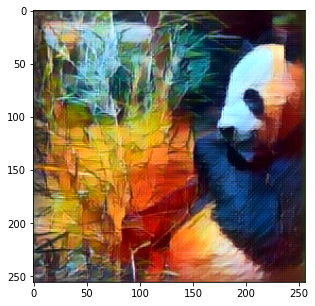

Saved sample tranformed image at images/out/sample0_9500.png
========Iteration 10001/10126========
	Content Loss:	2466374.00
	Style Loss:	1798436.62
	Total Loss:	4264811.22
Time elapsed:	1544.0565433502197 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_10000.pth


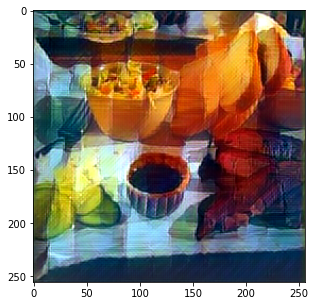

Saved sample tranformed image at images/out/sample0_10000.png
========Iteration 10126/10126========
	Content Loss:	2459985.00
	Style Loss:	1787772.05
	Total Loss:	4247757.87
Time elapsed:	1563.053647518158 seconds
Saved TransformerNetwork checkpoint file at models/checkpoint_10125.pth


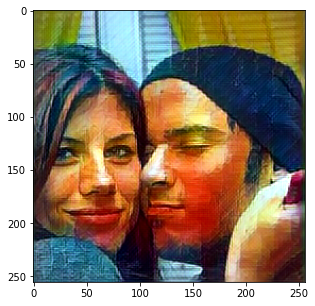

Saved sample tranformed image at images/out/sample0_10125.png
Done Training the Transformer Network!
Training Time: 1563.2354388237 seconds
========Content Loss========
[76701360.0, 17749421.723552894, 11804440.2012987, 9501176.956029315, 8219971.374812594, 7369909.62235106, 6770033.873125625, 6321209.908383319, 5969262.2561859535, 5683714.986669629, 5446002.957008598, 5246660.635611707, 5078920.4124312615, 4931839.875403784, 4799980.673868019, 4685033.81092521, 4582437.740251219, 4492117.117662628, 4409344.468614599, 4334578.654720556, 4264811.217353265, 4247757.868309303]
========Style Loss========
[73487872.0, 13374644.863772456, 7756125.727147852, 5719969.780313125, 4657160.532171414, 3995846.881747301, 3543705.611733589, 3214921.250267781, 2960517.4532148214, 2758711.4578982447, 2592997.363714757, 2455445.561147973, 2340227.9821279785, 2239685.1420550686, 2152397.8271943294, 2075746.8569107451, 2008047.2966504188, 1948014.7459048936, 1893311.7963698478, 1843927.1630025788, 1798436

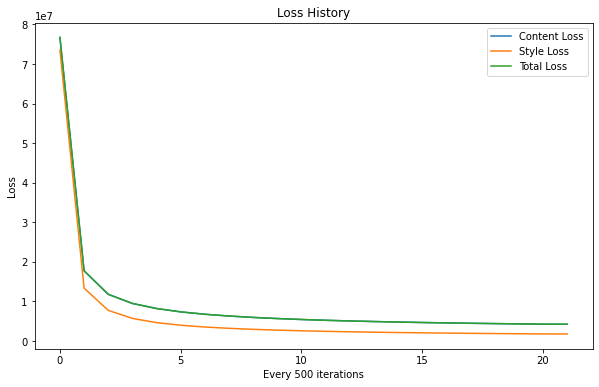

In [5]:
train()

In [6]:
# copy the models folder to the folder in the google drive
!cp -r models/ /content/gdrive/My\ Drive/models/
# copy the images folder to the folder in the google drive
!cp -r images/ /content/gdrive/My\ Drive/images/